<center><h1> The Annotated S4 </h1></center>


<center>
<p><a href="https://arxiv.org/abs/2111.00396">Efficiently Modeling Long Sequences with Structured State Spaces</a></p>
</center>

<center>
<p> Albert Gu, Karan Goel, and Christopher Ré.</p>
</center>
<img src="images/hero.png" width="100%"/>

*Blog Post and [Library](https://github.com/srush/annotated-s4/) by [Sasha Rush](http://rush-nlp.com/) and [Sidd Karamcheti](https://www.siddkaramcheti.com/)*, v2


The [Structured State Space for Sequence
Modeling](https://arxiv.org/abs/2111.00396) (S4) architecture is a new approach to very
long-range sequence modeling tasks for vision,
language, and audio, showing a capacity to capture dependencies over tens
of thousands of steps. Especially impressive are the model's results on the challenging
[Long Range Arena](https://github.com/google-research/long-range-arena) benchmark, showing an ability
to reason over sequences of up to **16,000+** elements with high accuracy.

<img src="images/table.png" width="100%"/>

The paper is also a refreshing departure from Transformers, taking a
very different approach to an important problem-space.  However,
several of our colleagues have also noted privately the difficulty
of gaining intuition for the model.  This blog post is a first step
towards this goal of gaining intuition, linking concrete code
implementations with explanations from the S4 paper – very much in
the style of [the annotated
Transformer](https://nlp.seas.harvard.edu/2018/04/03/attention.html).
Hopefully this combination of code and literate explanations helps
you follow the details of the model. By the end of the blog you will
have an efficient working version of S4 that can operate as a CNN
for training, but then convert to an efficient RNN at test time.  To
preview the results, you will be able to generate images from pixels
and sounds directly from audio waves on a standard GPU.

<center> <img src="images/im0.4.png" width="70%">
<img src='images/speech25.0.png' width='80%'>
<audio controls>
 <source src='images/sample25.0.wav' type='audio/wav'>
</audio>
<audio controls>
 <source src='images/sample25.0.gold.wav' type='audio/wav'>
</audio>
</center>

## Table of Contents

<nav id="TOC">
* [Part 1: State Space Models] (Modeling)
    - [Discrete-time SSM: The Recurrent Representation]
    - [Tangent: A Mechanics Example]
    - [Training SSMs: The Convolutional Representation]
    - [An SSM Neural Network.]
* [Part 1b: Addressing Long-Range Dependencies with HiPPO]
* [Part 2: Implementing S4] (Advanced)
    - [Step 1. SSM Generating Functions]
    - [Step 2: Diagonal Case]
    - [Step 3: Diagonal Plus Low-Rank]
    - [Diagonal Plus Low-Rank RNN.]
    - [Turning HiPPO to DPLR]
    - [Final Check]
* [Part 3: S4 in Practice] (NN Implementation)
    - [S4 CNN / RNN Layer]
    - [Sampling and Caching]
    - [Experiments: MNIST]
    - [Experiments: QuickDraw]
    - [Experiments: Spoken Digits]
* [Conclusion]
</nav>

<nav id="TOC">

Note that this project uses [JAX](https://github.com/google/jax/)
with the [Flax](https://github.com/google/flax) NN library.  While
we personally mainly use Torch, the functional nature of JAX is a good
fit for some of the complexities of S4. We make heavy use of
[vmap](https://jax.readthedocs.io/en/latest/jax.html#jax.vmap),
[scan](https://jax.readthedocs.io/en/latest/_autosummary/jax.lax.scan.html),
their [NN
cousins](https://flax.readthedocs.io/en/latest/flax.linen.html#module-flax.linen.transforms),
and most importantly
[jax.jit](https://jax.readthedocs.io/en/latest/notebooks/thinking_in_jax.html#jit-mechanics-tracing-and-static-variables)
to compile fast and efficient S4 layers.

In [3]:
from functools import partial
import jax
import jax.numpy as np
from flax import linen as nn
from jax.nn.initializers import lecun_normal, normal
from jax.numpy.linalg import eigh, inv, matrix_power
from jax.scipy.signal import convolve

In [4]:
if __name__ == '__main__':
    # For this tutorial, it'll be convenient to construct a global JAX rng key
    # But we don't want it when importing as a library
    rng = jax.random.PRNGKey(1)

## Part 1: State Space Models

Let's get started! Our goal is the efficient
modeling of long sequences. To do this, we are going to build a
new neural network layer based on State Space Models. By the end of
this section we will be able to build and run a model with this layer.
However, we are going to need some technical background. Let's work
our way through the background of the paper.

> The [state space model](https://en.wikipedia.org/wiki/State-space_representation) is defined by this simple equation.
> It maps a 1-D input signal $u(t)$ to an $N$-D latent state $x(t)$
> before projecting to a 1-D output signal $y(t)$.
$$
  \begin{aligned}
    x'(t) &= \boldsymbol{A}x(t) + \boldsymbol{B}u(t) \\
    y(t) &= \boldsymbol{C}x(t) + \boldsymbol{D}u(t)
  \end{aligned}
$$
> Our goal is
> to simply use the SSM as a black-box representation in a deep
> sequence model, where $\boldsymbol{A}, \boldsymbol{B}, \boldsymbol{C}, \boldsymbol{D}$ are
> parameters learned by gradient descent.  For the remainder, we will
> omit the parameter $\boldsymbol{D}$ for exposition (or equivalently,
> assume $\boldsymbol{D} = 0$  because the term $\boldsymbol{D}u$ can be
> viewed as a skip connection and is easy to compute).
>
> An SSM maps a input $u(t)$ to a state representation vector $x(t)$ and an output $y(t)$.
> For simplicity, we assume the input and output are one-dimensional, and the state representation
> is $N$-dimensional. The first equation defines the change in $x(t)$ over time.

Our SSMs will be defined by three matrices – $\boldsymbol{A}, \boldsymbol{B}, \boldsymbol{C}$ – which
we will learn. For now we begin with a random SSM, to define sizes,

In [5]:
def random_SSM(rng, N):
    a_r, b_r, c_r = jax.random.split(rng, 3)
    A = jax.random.uniform(a_r, (N, N))
    B = jax.random.uniform(b_r, (N, 1))
    C = jax.random.uniform(c_r, (1, N))
    return A, B, C

### Discrete-time SSM: The Recurrent Representation

> To be applied on a discrete input sequence $(u_0, u_1, \dots )$
> instead of continuous function $u(t)$, the SSM must be
> discretized by a **step size** $\Delta$ that represents the
> resolution of the input.  Conceptually, the inputs $u_k$ can be
> viewed as sampling an implicit underlying continuous signal $u(t)$,
> where $u_k = u(k \Delta)$.
>
> To discretize the continuous-time SSM, we use
> the [bilinear method](https://en.wikipedia.org/wiki/Bilinear_transform), which converts the
> state matrix $\boldsymbol{A}$ into an approximation $\boldsymbol{\overline{A}}$.  The discrete SSM is:
$$
\begin{aligned}
  \boldsymbol{\overline{A}} &= (\boldsymbol{I} - \Delta/2 \cdot \boldsymbol{A})^{-1}(\boldsymbol{I} + \Delta/2 \cdot \boldsymbol{A}) \\
  \boldsymbol{\overline{B}} &= (\boldsymbol{I} - \Delta/2 \cdot \boldsymbol{A})^{-1} \Delta \boldsymbol{B} \\
  \boldsymbol{\overline{C}} &= \boldsymbol{C}\\
\end{aligned}
$$

In [6]:
def discretize(A, B, C, step):
    I = np.eye(A.shape[0])
    BL = inv(I - (step / 2.0) * A)
    Ab = BL @ (I + (step / 2.0) * A)
    Bb = (BL * step) @ B
    return Ab, Bb, C

> This equation is now a *sequence-to-sequence* map $u_k \mapsto y_k$ instead of function-to-function.
> Moreover the state equation is now a recurrence in $x_k$, allowing the discrete SSM to be computed like an RNN.
> Concretely, $x_k \in \mathbb{R}^N$ can be viewed as a *hidden state* with transition matrix $\boldsymbol{\overline{A}}$.
$$
\begin{aligned}
  x_{k} &= \boldsymbol{\overline{A}} x_{k-1} + \boldsymbol{\overline{B}} u_k\\
  y_k &= \boldsymbol{\overline{C}} x_k \\
\end{aligned}
$$

As the paper says, this "step" function does look superficially like that of
an RNN. We can implement this with a
[scan](https://jax.readthedocs.io/en/latest/_autosummary/jax.lax.scan.html)
in JAX,

In [7]:
def scan_SSM(Ab, Bb, Cb, u, x0):
    def step(x_k_1, u_k):
        x_k = Ab @ x_k_1 + Bb @ u_k
        y_k = Cb @ x_k
        return x_k, y_k

    return jax.lax.scan(step, x0, u)

Putting everything together, we can run the SSM
by first discretizing, then iterating step by step,

In [8]:
def run_SSM(A, B, C, u):
    L = u.shape[0]
    N = A.shape[0]
    Ab, Bb, Cb = discretize(A, B, C, step=1.0 / L)

    # Run recurrence
    return scan_SSM(Ab, Bb, Cb, u[:, np.newaxis], np.zeros((N,)))[1]

### Tangent: A Mechanics Example

 To gain some more intuition and test our SSM implementation, we pause
 from machine learning to implement a [classic example from mechanics](https://en.wikipedia.org/wiki/State-space_representation#Moving_object_example).

 In this example, we consider the forward position $y(t)$ of a mass attached to a wall with a spring.
 Over time, varying force $u(t)$ is applied to this mass. The system is parameterized by mass ($m$),
 spring constant ($k$), friction constant ($b$). We can relate these with the following differential equation:

$$\begin{aligned}
my''(t) = u(t) - by'(t) - ky(t)
\end{aligned}
$$

Rewriting this in matrix form yields an SSM in the following form:

$$
\begin{aligned}
\boldsymbol{A} &= \begin{bmatrix} 0 & 1 \\ -k/m & -b/m \end{bmatrix}  \\
\boldsymbol{B} & = \begin{bmatrix} 0  \\ 1/m \end{bmatrix} & \boldsymbol{C} = \begin{bmatrix} 1 & 0  \end{bmatrix}  \\
\end{aligned}
$$

In [9]:
def example_mass(k, b, m):
    A = np.array([[0, 1], [-k / m, -b / m]])
    B = np.array([[0], [1.0 / m]])
    C = np.array([[1.0, 0]])
    return A, B, C

 Looking at the $\boldsymbol{C}$, we should be able to convince ourselves that the
 first dimension of the hidden state is the position (since that becomes $y(t)$).
 The second dimension is the velocity, as it is impacted by $u(t)$ through
 $\boldsymbol{B}$. The transition $\boldsymbol{A}$ relates these terms.


We'll set $u$ to be a continuous function of $t$,

In [10]:
@partial(np.vectorize, signature="()->()")
def example_force(t):
    x = np.sin(10 * t)
    return x * (x > 0.5)

 Let's run this SSM through our code.

In [17]:
def example_ssm():
    # SSM
    ssm = example_mass(k=40, b=5, m=1)
    print(f"AAA {ssm}")

    # L samples of u(t).
    L = 100
    step = 1.0 / L
    ks = np.arange(L)
    u = example_force(ks * step)

    # Approximation of y(t).
    y = run_SSM(*ssm, u)
    print(f"AAA {y}")

    # Plotting ---
    import matplotlib.pyplot as plt
    import seaborn
    from celluloid import Camera

    seaborn.set_context("paper")
    fig, (ax1, ax2, ax3) = plt.subplots(3)
    camera = Camera(fig)
    ax1.set_title("Force $u_k$")
    ax2.set_title("Position $y_k$")
    ax3.set_title("Object")
    ax1.set_xticks([], [])
    ax2.set_xticks([], [])

    # Animate plot over time
    for k in range(0, L, 2):
        ax1.plot(ks[:k], u[:k], color="red")
        ax2.plot(ks[:k], y[:k], color="blue")
        ax3.boxplot(
            [[y[k, 0] - 0.04, y[k, 0], y[k, 0] + 0.04]],
            showcaps=False,
            whis=False,
            vert=False,
            widths=10,
        )
        camera.snap()
    anim = camera.animate()
    anim.save("images/line.gif", dpi=150, writer="imagemagick")

AAA (Array([[  0.,   1.],
       [-40.,  -5.]], dtype=float32), Array([[0.],
       [1.]], dtype=float32), Array([[1., 0.]], dtype=float32))
AAA [[ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 2.75166840e-05]
 [ 1.12496433e-04]
 [ 2.59249791e-04]
 [ 4.70973406e-04]
 [ 7.49724102e-04]
 [ 1.09640614e-03]
 [ 1.51077088e-03]
 [ 1.99143053e-03]
 [ 2.53588334e-03]
 [ 3.14055150e-03]
 [ 3.80083174e-03]
 [ 4.51115565e-03]
 [ 5.26506081e-03]
 [ 6.05527405e-03]
 [ 6.87379949e-03]
 [ 7.71201681e-03]
 [ 8.56078602e-03]
 [ 9.41055734e-03]
 [ 1.02514867e-02]
 [ 1.10735502e-02]
 [ 1.18666673e-02]
 [ 1.25999916e-02]
 [ 1.32484576e-02]
 [ 1.38136698e-02]
 [ 1.42974835e-02]
 [ 1.47019792e-02]
 [ 1.50294444e-02]
 [ 1.52823580e-02]
 [ 1.54633652e-02]
 [ 1.55752655e-02]
 [ 1.56209907e-02]
 [ 1.56035861e-02]
 [ 1.55261979e-02]
 [ 1.53920501e-02]
 [ 1.52044315e-02]
 [ 1.49666788e-02]
 [ 1.46821635e-02]
 [ 1.43542727e-02]
 [ 1.39863994e-02]


MovieWriter imagemagick unavailable; using Pillow instead.


AAA


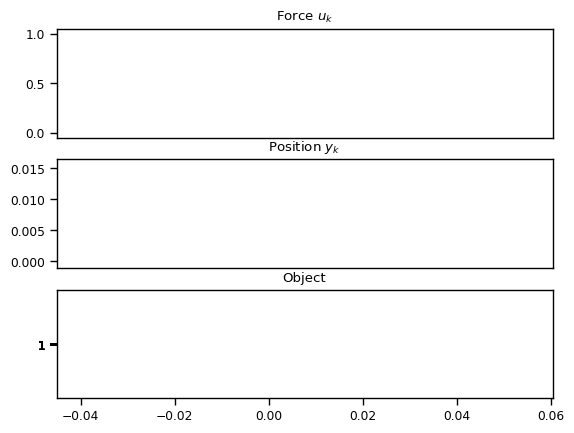

In [20]:
if True:
    example_ssm()

<img src="images/line.gif" width="100%">

Neat! And that it was just 1 SSM, with 2 hidden states over 100 steps.
The final model will have had **100s of stacked SSMs** over **thousands of steps**. But first – we
need to make these models practical to train.

### Training SSMs: The Convolutional Representation

The punchline of this section is that we can turn the "RNN" above into a "CNN"
by unrolling. Let's go through the derivation.

> The recurrent SSM is not practical for training on modern hardware
> due to its sequential nature.  Instead, there is a well-known connection
> between linear time-invariant (LTI) SSMs and
> continuous convolutions.  Correspondingly, the recurrent SSM can actually be
> written as a [discrete convolution](https://en.wikipedia.org/wiki/Convolution#Discrete_convolution).
>
> For simplicity let the initial state be $x_{-1} = 0$. Then unrolling  explicitly yields:
>
$$
\begin{aligned}
  x_0 &= \boldsymbol{\overline{B}} u_0 &
  x_1 &= \boldsymbol{\overline{A}} \boldsymbol{\overline{B}} u_0 + \boldsymbol{\overline{B}} u_1 &
  x_2 &= \boldsymbol{\overline{A}}^2 \boldsymbol{\overline{B}} u_0 + \boldsymbol{\overline{A}} \boldsymbol{\overline{B}} u_1 + \boldsymbol{\overline{B}} u_2 & \dots
  \\
  y_0 &= \boldsymbol{\overline{C}} \boldsymbol{\overline{B}} u_0 &
  y_1 &= \boldsymbol{\overline{C}} \boldsymbol{\overline{A}} \boldsymbol{\overline{B}} u_0 + \boldsymbol{\overline{C}} \boldsymbol{\overline{B}} u_1 &
  y_2 &= \boldsymbol{\overline{C}} \boldsymbol{\overline{A}}^2 \boldsymbol{\overline{B}} u_0 + \boldsymbol{\overline{C}} \boldsymbol{\overline{A}} \boldsymbol{\overline{B}} u_1 + \boldsymbol{\overline{C}} \boldsymbol{\overline{B}} u_2
  & \dots
\end{aligned}
$$
>
> This can be vectorized into a convolution with an explicit formula for the convolution kernel.
>
$$
\begin{aligned}
    y_k &= \boldsymbol{\overline{C}} \boldsymbol{\overline{A}}^k \boldsymbol{\overline{B}} u_0 + \boldsymbol{\overline{C}} \boldsymbol{\overline{A}}^{k-1} \boldsymbol{\overline{B}} u_1 + \dots + \boldsymbol{\overline{C}} \boldsymbol{\overline{A}} \boldsymbol{\overline{B}} u_{k-1} + \boldsymbol{\overline{C}}\boldsymbol{\overline{B}} u_k
    \\
    y &= \boldsymbol{\overline{K}} \ast u
\end{aligned}
$$
>
$$
\begin{aligned}
  \boldsymbol{\overline{K}} \in \mathbb{R}^L  = (\boldsymbol{\overline{C}}\boldsymbol{\overline{B}}, \boldsymbol{\overline{C}}\boldsymbol{\overline{A}}\boldsymbol{\overline{B}}, \dots, \boldsymbol{\overline{C}}\boldsymbol{\overline{A}}^{L-1}\boldsymbol{\overline{B}})
\end{aligned}
$$
We call $\boldsymbol{\overline{K}}$ the **SSM convolution kernel** or filter.

Note that this is a *giant* filter. It is the size of the entire sequence!

In [12]:
def K_conv(Ab, Bb, Cb, L):
    return np.array(
        [(Cb @ matrix_power(Ab, l) @ Bb).reshape() for l in range(L)]
    )

Warning: this implementation is naive and unstable. In practice it will fail to work
for more than very small lengths. However, we are going to replace it with S4 in Part 2, so for
now we just keep it around as a placeholder.

We can compute the result of applying this filter either with a standard direct convolution or
by using convolution theorem with [Fast Fourier Transform (FFT)](https://en.wikipedia.org/wiki/Convolution_theorem). The discrete convolution theorem - for circular convolution of two sequences - allows us to efficiently calculate the output of convolution by first multiplying FFTs of the input sequences and then applying an inverse FFT. To utilize this theorem for non-circular convolutions as in our case, we need to pad the input sequences with zeros, and then unpad the output sequence.
As the length gets longer this FFT method will be more efficient than the direct convolution,

In [13]:
def causal_convolution(u, K, nofft=False):
    if nofft:
        return convolve(u, K, mode="full")[: u.shape[0]]
    else:
        assert K.shape[0] == u.shape[0]
        ud = np.fft.rfft(np.pad(u, (0, K.shape[0])))
        Kd = np.fft.rfft(np.pad(K, (0, u.shape[0])))
        out = ud * Kd
        return np.fft.irfft(out)[: u.shape[0]]

The CNN method and the RNN method yield (roughly) the same result,

In [14]:
def test_cnn_is_rnn(N=4, L=16, step=1.0 / 16):
    ssm = random_SSM(rng, N)
    u = jax.random.uniform(rng, (L,))
    jax.random.split(rng, 3)
    # RNN
    rec = run_SSM(*ssm, u)

    # CNN
    ssmb = discretize(*ssm, step=step)
    conv = causal_convolution(u, K_conv(*ssmb, L))

    # Check
    assert np.allclose(rec.ravel(), conv.ravel())

### An SSM Neural Network.

We now have all of the machinery needed to build a basic SSM neural network layer.
As defined above, the discrete SSM defines a map from $\mathbb{R}^L
\to \mathbb{R}^L$, i.e. a 1-D sequence map. We assume that we
are going to be learning the parameters $B$ and $C$, as well as a
step size $\Delta$ and a scalar $D$ parameter. The HiPPO matrix is
used for the transition $A$. We learn the step size in log space.

In [15]:
def log_step_initializer(dt_min=0.001, dt_max=0.1):
    def init(key, shape):
        return jax.random.uniform(key, shape) * (
            np.log(dt_max) - np.log(dt_min)
        ) + np.log(dt_min)

    return init

For the SSM layer most of the work is to build the filter.
The actual call to the network is just the (huge) convolution we specified above.

Note for Torch users: `setup` in Flax is called each time the parameters are updated.
This is similar to the
[Torch parameterizations](https://pytorch.org/tutorials/intermediate/parametrizations.html).

As noted above this same layer can be used either as an RNN or a CNN. The argument
`decode` determines which path is used. In the case of RNN we cache the previous state
at each call in a Flax variable collection called `cache`.

In [16]:
class SSMLayer(nn.Module):
    N: int
    l_max: int
    decode: bool = False

    def setup(self):
        # SSM parameters
        self.A = self.param("A", lecun_normal(), (self.N, self.N))
        self.B = self.param("B", lecun_normal(), (self.N, 1))
        self.C = self.param("C", lecun_normal(), (1, self.N))
        self.D = self.param("D", nn.initializers.ones, (1,))

        # Step parameter
        self.log_step = self.param("log_step", log_step_initializer(), (1,))

        step = np.exp(self.log_step)
        self.ssm = discretize(self.A, self.B, self.C, step=step)
        self.K = K_conv(*self.ssm, self.l_max)

        # RNN cache for long sequences
        self.x_k_1 = self.variable("cache", "cache_x_k", np.zeros, (self.N,))

    def __call__(self, u):
        if not self.decode:
            # CNN Mode
            return causal_convolution(u, self.K) + self.D * u
        else:
            # RNN Mode
            x_k, y_s = scan_SSM(*self.ssm, u[:, np.newaxis], self.x_k_1.value)
            if self.is_mutable_collection("cache"):
                self.x_k_1.value = x_k
            return y_s.reshape(-1).real + self.D * u

Since our SSMs operate on scalars, we make $H$ different, stacked copies ($H$ different SSMs!) with
different parameters. Here we use the [Flax vmap](
https://flax.readthedocs.io/en/latest/_autosummary/flax.linen.vmap.html)
method to easily define these copies,

In [17]:
def cloneLayer(layer):
    return nn.vmap(
        layer,
        in_axes=1,
        out_axes=1,
        variable_axes={"params": 1, "cache": 1, "prime": 1},
        split_rngs={"params": True},
    )

In [18]:
SSMLayer = cloneLayer(SSMLayer)

This SSM Layer can then be put into a standard NN.
Here we add a block that pairs a call to an SSM with
dropout and a linear projection.

In [19]:
class SequenceBlock(nn.Module):
    layer: nn.Module
    layer_args: dict
    dropout: float
    d_model: int
    prenorm: bool = True
    glu: bool = True
    training: bool = True
    decode: bool = False

    def setup(self):
        self.seq = self.layer(**self.layer_args, decode=self.decode)
        self.norm = nn.LayerNorm()
        self.out = nn.Dense(self.d_model)
        if self.glu:
            self.out2 = nn.Dense(self.d_model)
        self.drop = nn.Dropout(
            self.dropout,
            broadcast_dims=[0],
            deterministic=not self.training,
        )

    def __call__(self, x):
        skip = x
        if self.prenorm:
            x = self.norm(x)
        x = self.seq(x)
        x = self.drop(nn.gelu(x))
        if self.glu:
            x = self.out(x) * jax.nn.sigmoid(self.out2(x))
        else:
            x = self.out(x)
        x = skip + self.drop(x)
        if not self.prenorm:
            x = self.norm(x)
        return x

We can then stack a bunch of these blocks on top of each other
to produce a stack of SSM layers. This can be used for
classification or generation in the standard way as a Transformer.

In [20]:
class StackedModel(nn.Module):
    layer: nn.Module
    layer_args: dict  # Extra arguments to pass into layer constructor
    d_output: int
    d_model: int
    n_layers: int
    dropout: float = 0.2
    training: bool = True
    classification: bool = False
    decode: bool = False  # Probably should be moved into layer_args

    def setup(self):
        self.encoder = nn.Dense(self.d_model)
        self.decoder = nn.Dense(self.d_output)
        self.layers = [
            SequenceBlock(
                layer=self.layer,
                layer_args=self.layer_args,
                d_model=self.d_model,
                dropout=self.dropout,
                training=self.training,
                decode=self.decode,
            )
            for _ in range(self.n_layers)
        ]

    def __call__(self, x):
        x = self.encoder(x)
        for layer in self.layers:
            x = layer(x)
        if self.classification:
            x = np.mean(x, axis=0)
        x = self.decoder(x)
        return nn.log_softmax(x, axis=-1)

In Flax we add the batch dimension as a lifted transformation.
We need to route through several variable collections which
handle RNN and parameter caching (described below).

In [21]:
BatchStackedModel = nn.vmap(
    StackedModel,
    in_axes=0,
    out_axes=0,
    variable_axes={"params": None, "dropout": None, "cache": 0, "prime": None},
    split_rngs={"params": False, "dropout": True},
)

Overall, this defines a sequence-to-sequence map of shape (batch size, sequence length, hidden dimension),
exactly the signature exposed by related sequence models such as Transformers, RNNs, and CNNs.

Full code for training is defined in
[training.py](https://github.com/srush/s4/blob/main/s4/train.py).

While we now have our main model, there are *two core problems with SSMs*. First, the randomly initialized SSM actually does not perform very well. Furthermore, computing it naively like we've done so far is really slow and memory inefficient.
Next, we'll complete our discussion of the modeling aspect of S4 by defining a special initialization for long-range dependencies,
and then figure out how to compute this SSM Layer faster – a lot faster (<a href="#part-2-implementing-s4">Part 2</a>)!

## Part 1b: Addressing Long-Range Dependencies with HiPPO

<img src="images/hippo.png" width="100%"/>

> [Prior work](https://arxiv.org/abs/2008.07669) found that the basic SSM actually performs very poorly in
> practice.  Intuitively, one explanation is that they  suffer from gradients scaling exponentially in the sequence length (i.e., the
> vanishing/exploding gradients problem).  To address this problem, previous work developed the HiPPO theory of
> continuous-time memorization.
>
> HiPPO specifies a class of certain matrices $\boldsymbol{A} \in \mathbb{R}^{N \times N}$ that when incorporated,
> allow the state $x(t)$ to memorize the history of the input $u(t)$.
> The most important matrix in this class is defined by the HiPPO matrix.
>
$$
\begin{aligned}
  (\text{\textbf{HiPPO Matrix}})
  \qquad
  \boldsymbol{A}_{nk}
  =
  \begin{cases}
    (2n+1)^{1/2}(2k+1)^{1/2} & \text{if } n > k \\
    n+1 & \text{if } n = k \\
    0 & \text{if } n < k
  \end{cases}
\end{aligned}
$$
>
> Previous work found that simply modifying an SSM from a random matrix $\boldsymbol{A}$ to HiPPO
> improved its performance on the sequential MNIST classification benchmark from $60\%$ to $98\%$.

This matrix is going to be really important, but it is a bit of
magic. For our purposes we mainly need to know that: 1) we only need to
calculate it once, and 2) it has a nice, simple structure (which we will exploit in
part 2). Without going into the ODE math, the main takeaway
is that this matrix aims to compress the past history into a state
that has enough information to approximately reconstruct the history.

In [22]:
def make_HiPPO(N):
    P = np.sqrt(1 + 2 * np.arange(N))
    A = P[:, np.newaxis] * P[np.newaxis, :]
    A = np.tril(A) - np.diag(np.arange(N))
    return -A

Diving a bit deeper, the intuitive explanation of this matrix is
that it produces a hidden state that memorizes its history. It does
this by keeping track of the coefficients of a [Legendre
polynomial](https://en.wikipedia.org/wiki/Legendre_polynomials). These
coefficients let it approximate all of the previous history. Let us
look at an example,

In [23]:
def example_legendre(N=8):
    # Random hidden state as coefficients
    import numpy as np
    import numpy.polynomial.legendre

    x = (np.random.rand(N) - 0.5) * 2
    t = np.linspace(-1, 1, 100)
    f = numpy.polynomial.legendre.Legendre(x)(t)

    # Plot
    import matplotlib.pyplot as plt
    import seaborn

    seaborn.set_context("talk")
    fig = plt.figure(figsize=(20, 10))
    ax = fig.gca(projection="3d")
    ax.plot(
        np.linspace(-25, (N - 1) * 100 + 25, 100),
        [0] * 100,
        zs=-1,
        zdir="x",
        color="black",
    )
    ax.plot(t, f, zs=N * 100, zdir="y", c="r")
    for i in range(N):
        coef = [0] * N
        coef[N - i - 1] = 1
        ax.set_zlim(-4, 4)
        ax.set_yticks([])
        ax.set_zticks([])
        # Plot basis function.
        f = numpy.polynomial.legendre.Legendre(coef)(t)
        ax.bar(
            [100 * i],
            [x[i]],
            zs=-1,
            zdir="x",
            label="x%d" % i,
            color="brown",
            fill=False,
            width=50,
        )
        ax.plot(t, f, zs=100 * i, zdir="y", c="b", alpha=0.5)
    ax.view_init(elev=40.0, azim=-45)
    fig.savefig("images/leg.png")

In [24]:
if False:
    example_legendre()

The red line represents that curve we are approximating,
while the black bars represent the values of our hidden state.
Each is a coefficient for one element of the Legendre series
shown as blue functions. The intuition is that the HiPPO matrix
updates these coefficients each step.

<img src="images/leg.png" width="100%">

## Part 2: Implementing S4

Warning: this section has a lot of math. Roughly it boils down to finding a
way to compute the filter from Part 1 for "HiPPO-like" matrices *really
fast*. If you are interested, the details are really neat. If not,
skip to Part 3 for some cool applications like MNIST completion.

[Skip Button](#part-3-s4-in-practice)

To set the stage, recall that S4 has two main differences from a basic SSM. The first addresses a *modeling challenge* - long-range dependencies - by using a special formula for the $\boldsymbol{A}$ matrix defined in the previous part. These special SSMs were considered in [predecessor](https://arxiv.org/abs/2110.13985) works to S4.

The second main feature of S4 solves the *computational challenge* of SSMs by introducing a special representation and algorithm to be able to work with this matrix!

> The fundamental bottleneck in computing the discrete-time SSM
> is that it involves repeated matrix multiplication by
> $\boldsymbol{\overline{A}}$.  For example, computing
> naively  involves $L$ successive multiplications
> by $\boldsymbol{\overline{A}}$, requiring $O(N^2 L)$ operations and
> $O(NL)$ space.

Specifically, recall this function here:

```python
def K_conv(Ab, Bb, Cb, L):
   return np.array(
       [(Cb @ matrix_power(Ab, l) @ Bb).reshape() for l in range(L)]
   )
```

The contribution of S4 is a stable method for speeding up this particular operation.
To do this we are going to focus on the case where the SSM
has special structure: specifically, Diagonal Plus Low-Rank (DPLR) in complex
space.

A **DPLR** SSM is $(\boldsymbol{\Lambda} - \boldsymbol{P}\boldsymbol{Q}^*, \boldsymbol{B}, \boldsymbol{C})$ for some diagonal $\boldsymbol{\Lambda}$ and matrices $\boldsymbol{P}, \boldsymbol{Q}, \boldsymbol{B}, \boldsymbol{C} \in \mathbb{C}^{N \times 1}$.
We assume without loss of generality that the rank is $1$, i.e. these matrices are vectors.

Under this DPLR assumption, S4 overcomes the speed bottleneck in three steps


>  1. Instead of computing $\boldsymbol{\overline{K}}$ directly,
    we compute its spectrum by evaluating its **[truncated generating function](https://en.wikipedia.org/wiki/Generating_function)** .  This  now involves a matrix *inverse* instead of *power*.
>  2. We show that the diagonal matrix case is equivalent to the computation of a **[Cauchy kernel](https://en.wikipedia.org/wiki/Cauchy_matrix)** $\frac{1}{\omega_j - \zeta_k}$.
>  3. We show the low-rank term can now be corrected by applying the **[Woodbury identity](https://en.wikipedia.org/wiki/Woodbury_matrix_identity)** which reduces $(\boldsymbol{\Lambda} + \boldsymbol{P}\boldsymbol{Q}^*)^{-1}$ in terms of $\boldsymbol{\Lambda}^{-1}$, truly reducing to the diagonal case.

### Step 1. SSM Generating Functions

The main step will be switching from computing the sequence to computing its generating function.
From the paper's appendix:

> To address the problem of computing powers of $\boldsymbol{\overline{A}}$, we introduce another technique.
> Instead of computing the SSM convolution filter $\boldsymbol{\overline{K}}$ directly,
> we introduce a generating function on its coefficients and compute evaluations of it.
>
>The *truncated SSM generating function* at node $z$ with truncation $L$ is
$$
\hat{\mathcal{K}}_L(z; \boldsymbol{\overline{A}}, \boldsymbol{\overline{B}}, \boldsymbol{\overline{C}}) \in \mathbb{C} := \sum_{i=0}^{L-1} \boldsymbol{\overline{C}} \boldsymbol{\overline{A}}^i \boldsymbol{\overline{B}} z^i
$$

In [25]:
def K_gen_simple(Ab, Bb, Cb, L):
    K = K_conv(Ab, Bb, Cb, L)

    def gen(z):
        return np.sum(K * (z ** np.arange(L)))

    return gen

> The generating function essentially converts the SSM convolution filter from the time domain to
> frequency domain. This transformation is also called [z-transform](https://en.wikipedia.org/wiki/Z-transform) (up to a minus sign) in control engineering literature. Importantly, it preserves the same information, and the desired SSM convolution filter
> can be recovered. Once the z-transform of a discrete sequence known, we can obtain the filter's discrete fourier transform from evaluations of its
> [z-transform at the roots of unity](https://en.wikipedia.org/wiki/Z-transform#Inverse_Z-transform)
$\Omega = \{ \exp(2\pi \frac{k}{L} : k \in [L] \}$. Then, we can apply inverse fourier transformation, stably in $O(L \log L)$ operations by applying an [FFT](https://en.wikipedia.org/wiki/Fast_Fourier_transform), to recover the filter.

In [26]:
def conv_from_gen(gen, L):
    # Evaluate at roots of unity
    # Generating function is (-)z-transform, so we evaluate at (-)root
    Omega_L = np.exp((-2j * np.pi) * (np.arange(L) / L))
    atRoots = jax.vmap(gen)(Omega_L)
    # Inverse FFT
    out = np.fft.ifft(atRoots, L).reshape(L)
    return out.real

More importantly, in the generating function we can replace the matrix power with an inverse!
$$
\hat{\mathcal{K}}_L(z) = \sum_{i=0}^{L-1} \boldsymbol{\overline{C}} \boldsymbol{\overline{A}}^i \boldsymbol{\overline{B}} z^i = \boldsymbol{\overline{C}} (\boldsymbol{I} - \boldsymbol{\overline{A}}^L z^L) (\boldsymbol{I} - \boldsymbol{\overline{A}} z)^{-1} \boldsymbol{\overline{B}} = \boldsymbol{\widetilde{C}}  (\boldsymbol{I} - \boldsymbol{\overline{A}} z)^{-1} \boldsymbol{\overline{B}}
$$

And for all $z \in \Omega_L$, we have $z^L = 1$ so that term is removed. We then pull this constant
term into a new $\boldsymbol{\widetilde{C}}$. Critically, this function **does not** call `K_conv`,

In [27]:
def K_gen_inverse(Ab, Bb, Cb, L):
    I = np.eye(Ab.shape[0])
    Ab_L = matrix_power(Ab, L)
    Ct = Cb @ (I - Ab_L)
    return lambda z: (Ct.conj() @ inv(I - Ab * z) @ Bb).reshape()

But it does output the same values,

In [28]:
def test_gen_inverse(L=16, N=4):
    ssm = random_SSM(rng, N)
    ssm = discretize(*ssm, 1.0 / L)
    b = K_conv(*ssm, L=L)

    a = conv_from_gen(K_gen_inverse(*ssm, L=L), L)
    assert np.allclose(a, b)

 In summary, Step 1 allows us to replace the matrix power with an
 inverse by utilizing a truncated generating function.
 However this inverse still needs to be calculated $L$
 times (for each of the roots of unity).

### Step 2: Diagonal Case

The next step to assume special *structure* on the matrix
$\boldsymbol{A}$ to compute the inverse faster than the naive inversion.
To begin, let us first convert the equation above to use the original SSM
matrices. With some algebra you can expand the discretization and show:

$$
\begin{aligned}
  \boldsymbol{\widetilde{C}}\left(\boldsymbol{I} - \boldsymbol{\overline{A}} \right)^{-1} \boldsymbol{\overline{B}}
  =
  \frac{2\Delta}{1+z} \boldsymbol{\widetilde{C}} \left[ {2 \frac{1-z}{1+z}} - \Delta \boldsymbol{A} \right]^{-1} \boldsymbol{B}
\end{aligned}
$$

Now imagine $\boldsymbol{A}=\boldsymbol{\Lambda}$ for a diagonal $\boldsymbol{\Lambda}$. Substituting in the discretization
formula the authors show that the generating function can be written in the following manner:

$$ \begin{aligned}
\boldsymbol{\hat{K}}_{\boldsymbol{\Lambda}}(z) & = c(z) \sum_i \cdot \frac{\boldsymbol{\widetilde{C}}_i \boldsymbol{B}_i} {(g(z) - \boldsymbol{\Lambda}_i)} = c(z) \cdot k_{z, \boldsymbol{\Lambda}}(\boldsymbol{\widetilde{C}}, \boldsymbol{B}) \\
 \end{aligned}$$
where $c$ is a constant, and $g$ is a function of $z$.

We have effectively replaced an inverse with a weighted dot product.
Let's make a small helper function to compute this weight dot product for use.

In [ ]:
def cauchy_dot(v, omega, lambd):
    return (v / (omega - lambd)).sum()

While not important for our implementation, it is worth noting that
this is a [Cauchy
kernel](https://en.wikipedia.org/wiki/Cauchy_matrix) and is the
subject of many other [fast
implementations](https://en.wikipedia.org/wiki/Fast_multipole_method).

### Step 3: Diagonal Plus Low-Rank

The final step is to relax the diagonal assumption. In addition to
the diagonal term we allow a low-rank component with
$\boldsymbol{P}, \boldsymbol{Q} \in \mathbb{C}^{N\times 1}$ such that:

$$
\boldsymbol{A} = \boldsymbol{\Lambda} - \boldsymbol{P}  \boldsymbol{Q}^*
$$

The [Woodbury identity](https://en.wikipedia.org/wiki/Woodbury_matrix_identity)
tells us that the inverse of a diagonal plus rank-1 term is equal to the
inverse of the diagonal plus a rank-1 term. We write it out here
adding the low-rank term.

$$ \begin{aligned}
(\boldsymbol{\Lambda} + \boldsymbol{P}  \boldsymbol{Q}^*)^{-1} &= \boldsymbol{\Lambda}^{-1} - \boldsymbol{\Lambda}^{-1} \boldsymbol{P} (1 + \boldsymbol{Q}^* \boldsymbol{\Lambda}^{-1} \boldsymbol{P})^{-1} \boldsymbol{Q}^* \boldsymbol{\Lambda}^{-1}
 \end{aligned}
$$

 There is a bunch of algebra in the appendix. It mostly consists of substituting this component in for A,
 applying the Woodbury identity and distributing terms. We end up with 4 terms that
 all look like Step 2 above:

$$ \begin{aligned}
\boldsymbol{\hat{K}}_{DPLR}(z) & = c(z) [k_{z, \Lambda}(\boldsymbol{\widetilde{C}}, \boldsymbol{\boldsymbol{B}}) - k_{z, \Lambda}(\boldsymbol{\widetilde{C}}, \boldsymbol{\boldsymbol{P}}) (1 + k_{z, \Lambda}(\boldsymbol{q^*}, \boldsymbol{\boldsymbol{P}}) )^{-1} k_{z, \Lambda}(\boldsymbol{q^*}, \boldsymbol{\boldsymbol{B}}) ]
 \end{aligned}$$

The code consists of collecting up the terms and applying 4 weighted dot products,

In [29]:
def K_gen_DPLR(Lambda, P, Q, B, C, step, unmat=False):
    aterm = (C.conj(), Q.conj())
    bterm = (B, P)

    def gen(o):
        g = (2.0 / step) * ((1.0 - o) / (1.0 + o))
        c = 2.0 / (1.0 + o)

        def k(a):
            # Checkpoint this calculation for memory efficiency.
            if unmat:
                return jax.remat(cauchy_dot)(a, g, Lambda)
            else:
                return cauchy_dot(a, g, Lambda)

        k00 = k(aterm[0] * bterm[0])
        k01 = k(aterm[0] * bterm[1])
        k10 = k(aterm[1] * bterm[0])
        k11 = k(aterm[1] * bterm[1])
        return c * (k00 - k01 * (1.0 / (1.0 + k11)) * k10)

    return gen

This is our final version of the $K$ function. Because `conv_from_gen` is always called together with a generating function (e.g. `K_gen_DPLR`), we'll fuse them into define a dedicated function to compute the DPLR SSM kernel from all of its parameters. (With fewer layers of indirection, this could also make it easier for XLA compiler to optimize.)

In [30]:
@jax.jit
def cauchy(v, omega, lambd):
    """Cauchy matrix multiplication: (n), (l), (n) -> (l)"""
    cauchy_dot = lambda _omega: (v / (_omega - lambd)).sum()
    return jax.vmap(cauchy_dot)(omega)

In [31]:
def kernel_DPLR(Lambda, P, Q, B, C, step, L):
    # Evaluate at roots of unity
    # Generating function is (-)z-transform, so we evaluate at (-)root
    Omega_L = np.exp((-2j * np.pi) * (np.arange(L) / L))

    aterm = (C.conj(), Q.conj())
    bterm = (B, P)

    g = (2.0 / step) * ((1.0 - Omega_L) / (1.0 + Omega_L))
    c = 2.0 / (1.0 + Omega_L)

    # Reduction to core Cauchy kernel
    k00 = cauchy(aterm[0] * bterm[0], g, Lambda)
    k01 = cauchy(aterm[0] * bterm[1], g, Lambda)
    k10 = cauchy(aterm[1] * bterm[0], g, Lambda)
    k11 = cauchy(aterm[1] * bterm[1], g, Lambda)
    atRoots = c * (k00 - k01 * (1.0 / (1.0 + k11)) * k10)
    out = np.fft.ifft(atRoots, L).reshape(L)
    return out.real

Now we can check whether it worked.
First, let's generate a random Diagonal Plus Low Rank (DPLR) matrix,

In [32]:
def random_DPLR(rng, N):
    l_r, p_r, q_r, b_r, c_r = jax.random.split(rng, 5)
    Lambda = jax.random.uniform(l_r, (N,))
    P = jax.random.uniform(p_r, (N,))
    Q = jax.random.uniform(q_r, (N,))
    B = jax.random.uniform(b_r, (N, 1))
    C = jax.random.uniform(c_r, (1, N))
    return Lambda, P, Q, B, C

We can check that the DPLR method yields the same filter as computing $\boldsymbol{A}$ directly,

In [33]:
def test_gen_dplr(L=16, N=4):
    I = np.eye(4)

    # Create a DPLR A matrix and discretize
    Lambda, P, B, _ = make_DPLR_HiPPO(N)
    A = np.diag(Lambda) - P[:, np.newaxis] @ P[:, np.newaxis].conj().T
    _, _, C = random_SSM(rng, N)

    Ab, Bb, Cb = discretize(A, B, C, 1.0 / L)
    a = K_conv(Ab, Bb, Cb.conj(), L=L)

    # Compare to the DPLR generating function approach.
    C = (I - matrix_power(Ab, L)).conj().T @ Cb.ravel()
    b = kernel_DPLR(Lambda, P, P, B, C, step=1.0 / L, L=L)
    assert np.allclose(a.real, b.real)

### Diagonal Plus Low-Rank RNN.

A secondary benefit of the DPLR factorization is that it allows
us to compute the discretized form of the SSM without having
to invert the $A$ matrix directly. Here we return to the paper
for the derivation.

> Recall that discretization computes,
$$
\begin{align*}
  \bm{\overline{A}} &= (\bm{I} - \Delta/2 \cdot \bm{A})^{-1}(\bm{I} + \Delta/2 \cdot \bm{A}) \\
  \bm{\overline{B}} &= (\bm{I} - \Delta/2 \cdot \bm{A})^{-1} \Delta \bm{B}
  .
\end{align*}
$$
>
> We simplify both terms in the definition of $\bm{\overline{A}}$ independently.
> The first term is:
$$
\begin{align*}
  \bm{I} + \frac{\Delta}{2} \bm{A}
  &= \bm{I} + \frac{\Delta}{2} (\bm{\Lambda} - \bm{P} \bm{Q}^*)
  \\&= \frac{\Delta}{2} \left[ \frac{2}{\Delta}\bm{I} + (\bm{\Lambda} - \bm{P} \bm{Q}^*) \right]
  \\&= \frac{\Delta}{2} \bm{A_0}
\end{align*}
$$
> where $\bm{A_0}$ is defined as the term in the final brackets.
>
> The second term is known as the Backward Euler's method.
> Although this inverse term is normally difficult to deal with,
> in the DPLR case we can simplify it using Woodbury's Identity as described above.
$$
\begin{align*}
  \left( \bm{I} - \frac{\Delta}{2} \bm{A} \right)^{-1}
  &=
  \left( \bm{I} - \frac{\Delta}{2} (\bm{\Lambda} - \bm{P} \bm{Q}^*) \right)^{-1}
  \\&=
  \frac{2}{\Delta} \left[ \frac{2}{\Delta} - \bm{\Lambda} + \bm{P} \bm{Q}^* \right]^{-1}
  \\&=
  \frac{2}{\Delta} \left[ \bm{D} - \bm{D} \bm{P} \left( 1 + \bm{Q}^* \bm{D} \bm{P} \right)^{-1} \bm{Q}^* \bm{D} \right]
  \\&= \frac{2}{\Delta} \bm{A_1}
\end{align*}
$$
> where $\bm{D} = \left( \frac{2}{\Delta}-\bm{\Lambda} \right)^{-1}$
> and $\bm{A_1}$ is defined as the term in the final brackets.
>
>  The discrete-time SSM \eqref{eq:2} becomes
$$
\begin{align*}
  x_{k} &= \bm{\overline{A}} x_{k-1} + \bm{\overline{B}} u_k \\
  &= \bm{A_1} \bm{A_0} x_{k-1} + 2 \bm{A_1} \bm{B} u_k \\
  y_k &= \bm{C} x_k
  .
\end{align*}
$$

In [34]:
def discrete_DPLR(Lambda, P, Q, B, C, step, L):
    # Convert parameters to matrices
    B = B[:, np.newaxis]
    Ct = C[np.newaxis, :]

    N = Lambda.shape[0]
    A = np.diag(Lambda) - P[:, np.newaxis] @ Q[:, np.newaxis].conj().T
    I = np.eye(N)

    # Forward Euler
    A0 = (2.0 / step) * I + A

    # Backward Euler
    D = np.diag(1.0 / ((2.0 / step) - Lambda))
    Qc = Q.conj().T.reshape(1, -1)
    P2 = P.reshape(-1, 1)
    A1 = D - (D @ P2 * (1.0 / (1 + (Qc @ D @ P2))) * Qc @ D)

    # A bar and B bar
    Ab = A1 @ A0
    Bb = 2 * A1 @ B

    # Recover Cbar from Ct
    Cb = Ct @ inv(I - matrix_power(Ab, L)).conj()
    return Ab, Bb, Cb.conj()

### Turning HiPPO to DPLR

This approach applies to DPLR matrices, but remember we would like it to also apply to the HiPPO matrix.
 While not DPLR in its current form, the HiPPO matrix *does have special structure*. It is
 Normal Plus Low-Rank (NPLR). Because [normal](https://en.wikipedia.org/wiki/Normal_matrix) matrices are exactly the class of matrices that are unitarily diagonalizable, NPLR matrices are essentially equivalent to DPLR matrices from the perspective of SSM models.
this is just as good as DPLR for the purposes of learning an SSM network.

> The S4 techniques can apply to any matrix $\boldsymbol{A}$ that can be decomposed as *Normal Plus Low-Rank (NPLR)*.
$$
>   \boldsymbol{A} = \boldsymbol{V} \boldsymbol{\Lambda} \boldsymbol{V}^* - \boldsymbol{P} \boldsymbol{Q}^\top = \boldsymbol{V} \left( \boldsymbol{\Lambda} - \boldsymbol{V}^* \boldsymbol{P} (\boldsymbol{V}^*\boldsymbol{Q})^* \right) \boldsymbol{V}^*
$$
> for [unitary](https://en.wikipedia.org/wiki/Unitary_matrix) $\boldsymbol{V} \in \mathbb{C}^{N \times N}$, diagonal $\boldsymbol{\Lambda}$, and low-rank factorization $\boldsymbol{P}, \boldsymbol{Q} \in \mathbb{R}^{N \times r}$.  An NPLR SSM is therefore unitarily equivalent to some DPLR matrix.

 For S4, we need to work with a HiPPO matrix for $\boldsymbol{A}$. This requires first writing it as a normal plus low-rank term, and then diagonalizing to extract
 $\boldsymbol{\Lambda}$ from this decomposition. The appendix of the paper shows how
 by writing the normal part as a [skew-symmetric](https://en.wikipedia.org/wiki/Skew-symmetric_matrix) (plus a constant times the identity matrix), which are a special class of normal matrices.

An additional simplification is that there is actually a representation that ties the low-rank components terms $\boldsymbol{P} = \boldsymbol{Q}$, which was shown in [follow-up work](https://arxiv.org/abs/2202.09729) to be important for stability.

In [35]:
def make_NPLR_HiPPO(N):
    # Make -HiPPO
    nhippo = make_HiPPO(N)

    # Add in a rank 1 term. Makes it Normal.
    P = np.sqrt(np.arange(N) + 0.5)

    # HiPPO also specifies the B matrix
    B = np.sqrt(2 * np.arange(N) + 1.0)
    return nhippo, P, B

After extracting the normal part, we can diagonalize to get out the DPLR terms.
Because the normal part is actually skew-symmetric, we can extract the real and complex parts of $\boldsymbol{\Lambda}$ separately.
This serves two purposes. First, this gives us finer-grained control over the real and imaginary parts, which can be used to improve stability. Second, this lets us use more powerful diagonalization algorithms for [Hermitian matrices](https://en.wikipedia.org/wiki/Hermitian_matrix) - in fact, the current version of JAX does not support GPU diagonalization for non-Hermitian matrices!

In [36]:
def make_DPLR_HiPPO(N):
    """Diagonalize NPLR representation"""
    A, P, B = make_NPLR_HiPPO(N)

    S = A + P[:, np.newaxis] * P[np.newaxis, :]

    # Check skew symmetry
    S_diag = np.diagonal(S)
    Lambda_real = np.mean(S_diag) * np.ones_like(S_diag)
    # assert np.allclose(Lambda_real, S_diag, atol=1e-3)

    # Diagonalize S to V \Lambda V^*
    Lambda_imag, V = eigh(S * -1j)

    P = V.conj().T @ P
    B = V.conj().T @ B
    return Lambda_real + 1j * Lambda_imag, P, B, V

Sanity check just to make sure those identities hold,

In [37]:
def test_nplr(N=8):
    A2, P, B = make_NPLR_HiPPO(N)
    Lambda, Pc, Bc, V = make_DPLR_HiPPO(N)
    Vc = V.conj().T
    P = P[:, np.newaxis]
    Pc = Pc[:, np.newaxis]
    Lambda = np.diag(Lambda)

    A3 = V @ Lambda @ Vc - (P @ P.T)  # Test NPLR
    A4 = V @ (Lambda - Pc @ Pc.conj().T) @ Vc  # Test DPLR
    assert np.allclose(A2, A3, atol=1e-4, rtol=1e-4)
    assert np.allclose(A2, A4, atol=1e-4, rtol=1e-4)

### Final Check

This tests that everything works as planned.

In [38]:
def test_conversion(N=8, L=16):
    step = 1.0 / L
    # Compute a HiPPO NPLR matrix.
    Lambda, P, B, _ = make_DPLR_HiPPO(N)
    # Random complex Ct
    C = normal(dtype=np.complex64)(rng, (N,))

    # CNN form.
    K = kernel_DPLR(Lambda, P, P, B, C, step, L)

    # RNN form.
    Ab, Bb, Cb = discrete_DPLR(Lambda, P, P, B, C, step, L)
    K2 = K_conv(Ab, Bb, Cb, L=L)
    assert np.allclose(K.real, K2.real, atol=1e-5, rtol=1e-5)

    # Apply CNN
    u = np.arange(L) * 1.0
    y1 = causal_convolution(u, K.real)

    # Apply RNN
    _, y2 = scan_SSM(
        Ab, Bb, Cb, u[:, np.newaxis], np.zeros((N,)).astype(np.complex64)
    )
    assert np.allclose(y1, y2.reshape(-1).real, atol=1e-4, rtol=1e-4)

## Part 3: S4 in Practice

That was a lot of work, but now the actual model is concise. In fact
we are only using four functions:

1. `K_gen_DPLR` → Truncated generating function when $\boldsymbol{A}$ is DPLR (S4-part)
2. `conv_from_gen` → Convert generating function to filter
3. `causal_convolution` → Run convolution
4. `discretize_DPLR` → Convert SSM to discrete form for RNN.

### S4 CNN / RNN Layer

 A full S4 Layer is very similar to the simple SSM layer above. The
 only difference is in the the computation of $\boldsymbol{K}$.
 Additionally instead of learning $\boldsymbol{C}$, we learn
 $\boldsymbol{\widetilde{C}}$ so we avoid computing powers of
 $\boldsymbol{A}$. Note as well that in the original paper $\boldsymbol{\Lambda}, \boldsymbol{P}, \boldsymbol{Q}$ are
 also learned. However, in this post, we leave them fixed for simplicity.

In [39]:
class S4Layer(nn.Module):
    N: int
    l_max: int
    decode: bool = False

    # Special parameters with multiplicative factor on lr and no weight decay (handled by main train script)
    lr = {
        "Lambda_re": 0.1,
        "Lambda_im": 0.1,
        "P": 0.1,
        "B": 0.1,
        "log_step": 0.1,
    }

    def setup(self):
        # Learned Parameters (C is complex!)
        init_A_re, init_A_im, init_P, init_B = hippo_initializer(self.N)
        self.Lambda_re = self.param("Lambda_re", init_A_re, (self.N,))
        self.Lambda_im = self.param("Lambda_im", init_A_im, (self.N,))
        # Ensure the real part of Lambda is negative
        # (described in the SaShiMi follow-up to S4)
        self.Lambda = np.clip(self.Lambda_re, None, -1e-4) + 1j * self.Lambda_im
        self.P = self.param("P", init_P, (self.N,))
        self.B = self.param("B", init_B, (self.N,))
        # C should be init as standard normal
        # This doesn't work due to how JAX handles complex optimizers https://github.com/deepmind/optax/issues/196
        # self.C = self.param("C", normal(stddev=1.0, dtype=np.complex64), (self.N,))
        self.C = self.param("C", normal(stddev=0.5**0.5), (self.N, 2))
        self.C = self.C[..., 0] + 1j * self.C[..., 1]
        self.D = self.param("D", nn.initializers.ones, (1,))
        self.step = np.exp(self.param("log_step", log_step_initializer(), (1,)))

        if not self.decode:
            # CNN mode, compute kernel.
            self.K = kernel_DPLR(
                self.Lambda,
                self.P,
                self.P,
                self.B,
                self.C,
                self.step,
                self.l_max,
            )

        else:
            # RNN mode, discretize

            # Flax trick to cache discrete form during decoding.
            def init_discrete():
                return discrete_DPLR(
                    self.Lambda,
                    self.P,
                    self.P,
                    self.B,
                    self.C,
                    self.step,
                    self.l_max,
                )

            ssm_var = self.variable("prime", "ssm", init_discrete)
            if self.is_mutable_collection("prime"):
                ssm_var.value = init_discrete()
            self.ssm = ssm_var.value

            # RNN Cache
            self.x_k_1 = self.variable(
                "cache", "cache_x_k", np.zeros, (self.N,), np.complex64
            )

    def __call__(self, u):
        # This is identical to SSM Layer
        if not self.decode:
            # CNN Mode
            return causal_convolution(u, self.K) + self.D * u
        else:
            # RNN Mode
            x_k, y_s = scan_SSM(*self.ssm, u[:, np.newaxis], self.x_k_1.value)
            if self.is_mutable_collection("cache"):
                self.x_k_1.value = x_k
            return y_s.reshape(-1).real + self.D * u

In [40]:
S4Layer = cloneLayer(S4Layer)

We initialize the model by computing a HiPPO DPLR initializer

In [41]:
# Factory for constant initializer in Flax
def init(x):
    def _init(key, shape):
        assert shape == x.shape
        return x

    return _init

In [42]:
def hippo_initializer(N):
    Lambda, P, B, _ = make_DPLR_HiPPO(N)
    return init(Lambda.real), init(Lambda.imag), init(P), init(B)

### Sampling and Caching

We can sample from the model using the RNN implementation. Here is
what the sampling code looks like. Note that we keep a running cache
to remember the RNN state.

In [43]:
def sample(model, params, prime, cache, x, start, end, rng):
    def loop(i, cur):
        x, rng, cache = cur
        r, rng = jax.random.split(rng)
        out, vars = model.apply(
            {"params": params, "prime": prime, "cache": cache},
            x[:, np.arange(1, 2) * i],
            mutable=["cache"],
        )

        def update(x, out):
            p = jax.random.categorical(r, out[0])
            x = x.at[i + 1, 0].set(p)
            return x

        x = jax.vmap(update)(x, out)
        return x, rng, vars["cache"].unfreeze()

    return jax.lax.fori_loop(start, end, jax.jit(loop), (x, rng, cache))[0]

To get this in a good form, we first precompute the discretized
version of the the RNN for each S4 layers. We do this through the
"prime" collection of variables.

In [44]:
def init_from_checkpoint(model, checkpoint, init_x):
    from flax.training import checkpoints

    print("[*] Loading")
    state = checkpoints.restore_checkpoint(checkpoint, None)
    assert "params" in state
    print("[*] Initializing")
    variables = model.init(rng, init_x)
    vars = {
        "params": state["params"],
        "cache": variables["cache"].unfreeze(),
        "prime": variables["prime"].unfreeze(),
    }
    print("[*] Priming")
    _, prime_vars = model.apply(vars, init_x, mutable=["prime"])
    return vars["params"], prime_vars["prime"], vars["cache"]

Putting this altogether we can sample from a model directly.

In [45]:
def sample_checkpoint(path, model, length):
    start = np.zeros((1, length, 1))
    print("[*] Initializing from checkpoint %s" % path)
    params, prime, cache = init_from_checkpoint(model, path, start[:, :-1])
    print("[*] Sampling output")
    return sample(model, params, prime, cache, start, 0, length - 1, rng)

### Experiments: MNIST

Now that we have the model, we can try it out on some MNIST experiments.
For these experiments we linearize MNIST and just treat each image as a sequence of
pixels.

The first experiments we ran were on MNIST classification. While
not in theory a hard problem, treating MNIST as a linear sequence
classification task is a bit strange. However in practice, the model
with $H=256$ and four layers seems to get up near 99% right away.

A more visually interesting task is generating MNIST digits, by predicting entire
sequences of pixels! Here, we simply feed in a sequence of pixels into the model and have it
predict the next one like language modeling. With a little
tweaking, we are able to get the model to an NLL of 0.52 on this
task with size 512 and 6 layers (~2m parameters).

The metric usually used for this task is *[bits per
dimension](https://paperswithcode.com/sota/image-generation-on-mnist)* which is
NLL in base 2 for MNIST. A score of 0.52 is ~0.76 BPD which is near PixelCNN++.

<img src="images/sample.png" width="100%">

We can also do prefix-samples – given the first 300 pixels, try to complete the image.
S4 is on the left, true on the right.

<img src="images/im0.1.png" width="45%">
<img src="images/im0.2.png" width="45%">
<img src="images/im0.3.png" width="45%">
<img src="images/im0.4.png" width="45%">
<img src="images/im0.5.png" width="45%">
<img src="images/im0.6.png" width="45%">
<img src="images/im0.7.png" width="45%">
<img src="images/im0.8.png" width="45%">

In [46]:
def sample_mnist_prefix(path, model, length):
    import matplotlib.pyplot as plt
    import numpy as onp
    from .data import Datasets

    BATCH = 32
    START = 300
    start = np.zeros((BATCH, length, 1))
    params, prime, init_cache = init_from_checkpoint(model, path, start[:, :-1])

    _, testloader, _, _, _ = Datasets["mnist"](bsz=BATCH)
    it = iter(testloader)
    for j, im in enumerate(it):
        image = im[0].numpy()

        cur = onp.array(image)
        cur[:, START + 1 :, 0] = 0
        cur = np.array(cur)

        # Cache the first `start` inputs.
        out, vars = model.apply(
            {"params": params, "prime": prime, "cache": init_cache},
            cur[:, np.arange(0, START)],
            mutable=["cache"],
        )
        cache = vars["cache"].unfreeze()
        out = sample(model, params, prime, cache, cur, START, length - 1, rng)
        print(j)

        # Visualization
        out = out.reshape(BATCH, 28, 28)
        final = onp.zeros((BATCH, 28, 28, 3))
        final2 = onp.zeros((BATCH, 28, 28, 3))
        final[:, :, :, 0] = out
        f = final.reshape(BATCH, 28 * 28, 3)
        i = image.reshape(BATCH, 28 * 28)
        f[:, :START, 1] = i[:, :START]
        f[:, :START, 2] = i[:, :START]
        f = final2.reshape(BATCH, 28 * 28, 3)
        f[:, :, 1] = i
        f[:, :START, 0] = i[:, :START]
        f[:, :START, 2] = i[:, :START]
        for k in range(BATCH):
            fig, (ax1, ax2) = plt.subplots(ncols=2)
            ax1.set_title("Sampled")
            ax1.imshow(final[k] / 256.0)
            ax2.set_title("True")
            ax1.axis("off")
            ax2.axis("off")
            ax2.imshow(final2[k] / 256.0)
            fig.savefig("im%d.%d.png" % (j, k))
            print(j)

### Experiments: QuickDraw

Next we tried training a model to generate drawings. For this we
used the [QuickDraw
dataset](https://github.com/googlecreativelab/quickdraw-dataset).
The dataset includes a version of the dataset downsampled to MNIST
size so we can use roughly the same model as above. The dataset
is much larger though (5M images) and more complex. We only trained
for 1 epoch with a $H=256$, 4 layer model. Still, the approach was
able to generate relatively coherent completions. These are prefix
samples with 500 pixels given.

<img src="images/quickdraw/im1.png" width="45%">
<img src="images/quickdraw/im2.png" width="45%">
<img src="images/quickdraw/im3.png" width="45%">
<img src="images/quickdraw/im4.png" width="45%">
<img src="images/quickdraw/im5.png" width="45%">
<img src="images/quickdraw/im6.png" width="45%">

### Experiments: Spoken Digits

Finally we played with modeling sound waves directly. For these, we
use the
[Free Spoken Digits Datasets](https://github.com/Jakobovski/free-spoken-digit-dataset)
an MNIST like dataset of various speakers reading off digits. We
first trained a classification model and found that the approach was
able to reach $97\%$ accuracy just from the raw soundwave. Next we
trained a generation model to produce the sound wave directly. With
$H=512$ the model seems to pick up the data relatively well. This
dataset only has around 3000 examples, but the model can produce
reasonably good (cherry-picked) continuations. Note these sequences are 6400 steps
long at an 8kHz sampling rate, discretized to 256 classes with
[Mu Law Encoding](https://en.wikipedia.org/wiki/%CE%9C-law_algorithm).

<center>
<img src='images/speech3.1.png' width='100%'>
<audio controls>
 <source src='images/sample3.1.wav' type='audio/wav'>
</audio>
<audio controls>
 <source src='images/sample3.1.gold.wav' type='audio/wav'>
</audio>

<img src='images/speech6.1.png' width='100%'>
<audio controls>
 <source src='images/sample6.1.wav' type='audio/wav'>
</audio>
<audio controls>
 <source src='images/sample6.1.gold.wav' type='audio/wav'>
</audio>

<img src='images/speech7.0.png' width='100%'>
<audio controls>
 <source src='images/sample7.0.wav' type='audio/wav'>
</audio>
<audio controls>
 <source src='images/sample7.0.gold.wav' type='audio/wav'>
</audio>

<img src='images/speech9.0.png' width='100%'>
<audio controls>
 <source src='images/sample9.0.wav' type='audio/wav'>
</audio>
<audio controls>
 <source src='images/sample9.0.gold.wav' type='audio/wav'>
</audio>

<img src='images/speech10.0.png' width='100%'>
<audio controls>
 <source src='images/sample10.0.wav' type='audio/wav'>
</audio>
<audio controls>
 <source src='images/sample10.0.gold.wav' type='audio/wav'>
</audio>

<img src='images/speech13.1.png' width='100%'>
<audio controls>
 <source src='images/sample13.1.wav' type='audio/wav'>
</audio>
<audio controls>
 <source src='images/sample13.1.gold.wav' type='audio/wav'>
</audio>

<img src='images/speech23.0.png' width='100%'>
<audio controls>
 <source src='images/sample23.0.wav' type='audio/wav'>
</audio>
<audio controls>
 <source src='images/sample23.0.gold.wav' type='audio/wav'>
</audio>

<img src='images/speech25.0.png' width='100%'>
<audio controls>
 <source src='images/sample25.0.wav' type='audio/wav'>
</audio>
<audio controls>
 <source src='images/sample25.0.gold.wav' type='audio/wav'>
</audio>

<img src='images/speech26.0.png' width='100%'>
<audio controls>
 <source src='images/sample26.0.wav' type='audio/wav'>
</audio>
<audio controls>
 <source src='images/sample26.0.gold.wav' type='audio/wav'>
</audio>

<img src='images/speech26.1.png' width='100%'>
<audio controls>
 <source src='images/sample26.1.wav' type='audio/wav'>
</audio>
<audio controls>
 <source src='images/sample26.1.gold.wav' type='audio/wav'>
</audio>
</center>

Our [full code base](https://github.com/srush/annotated-s4/) contains
more examples and infrastructure for training models for generations and
classification.

## Conclusion

Putting together this post inspired lots of thoughts about future
work in this area. One obvious conclusion is that long-range
models have all sorts of future applications from acoustic modeling to
genomic sequences to trajectories (not to mention our shared area of
NLP). Another is some surprise that linear models can be so effective
here, while also opening up a range of efficient techniques.
Finally from a practical level, the transformations in JAX
make it really nice to implement complex models like this
in a very concise way (~200 LoC), with similar efficiency and performance!

We end by thanking the authors [Albert Gu](http://web.stanford.edu/~albertgu/) and
[Karan Goel](https://krandiash.github.io/), who were super helpful in
putting this together, and pointing you again to their
[paper](https://arxiv.org/abs/2111.00396) and
[codebase](https://github.com/HazyResearch/state-spaces).
Thanks to Ankit Gupta, Ekin Akyürek, Qinsheng Zhang, Nathan Yan, and Junxiong Wang for
contributions.
We're also grateful for Conner Vercellino and
Laurel Orr for providing helpful feedback on this post.


/ Cheers – Sasha & Sidd